# Part 3: Toxicity

In this part, you will analyze a number of real-world social media comments and attempt to classify them as normal, toxic, or severely toxic. Such a multiclassification model can serve as an example component in a content moderation system. The dataset was originally released as part of an open competition by the Google Jigsaw team, which went on to create the public [Jigsaw API](https://perspectiveapi.com) for toxic speech detection. 

**Learning objectives.** You will:
1. Use a Bag-Of-Words model to represent text data as count vectors.
2. Fit and validate a regularized text multiclassification model using logistic regression. 
3. Consider the problem of data imbalance and consider resampling and reweighting strategies to mitigate the problem. 
4. Read opinion pieces and articulate a position on the societal application of machine learning models for content moderation systems.

**Warning** Many of the comments contained in the data for this part **are offensive** -- the goal of the model you build will be to detect and help filter such comments. The comments in the data in no way represent the views of Duke University; the data were collected and made public by the [Google Jigsaw team](https://jigsaw.google.com/issues/). You may wish to avoid viewing the comments directly, and you are not required to view them directly to complete this assignment.

## Task 1

The dataset `toxic.csv` included with this project is in the following format. The example below is artificial and not part of the dataset.

| id               | comment_text                          | toxic | severe_toxic | obscene | threat | insult | identity_hate |
|------------------|---------------------------------------|-------|--------------|---------|--------|--------|---------------|
| 0880df08u        | I love Duke! What a great University. | 0     | 0            | 0       | 0      | 0      | 0             |
| 08234hhf1 | You are a terrible person.            | 1     | 0            | 0       | 0      | 0      | 0             |
| 2843jdf42 | BLANK People are such EXPLETIVE, I hate them   | 1     | 1            | 1       | 0      | 1      | 1             |



Your first task is to transform this data into a format that you can use to build a **3-class multiclassification model** that takes the `comment_text` as input and predicts whether the comment is normal (class 0), toxic (class 1), or severely toxic (class 2).


You have several options for loading the data:
- **[Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)** (recommended): Easy to work with and handles strings well
- **[Python csv module](https://docs.python.org/3/library/csv.html)**: Basic functionality and requires more manual processing
- **[NumPy utilities](https://numpy.org/doc/stable/user/how-to-io.html)**: May have difficulty with string data


### Creating the Target Variable

Create a single target variable `y` that encodes three classes as integers:
- **Class 0 (Normal)**: Comments where both `toxic = 0` and `severe_toxic = 0`
- **Class 1 (Toxic)**: Comments where `toxic = 1` but `severe_toxic = 0`  
- **Class 2 (Severely Toxic)**: Comments where `severe_toxic = 1` (regardless of the `toxic` column value)

You can implement this logic as follows:
```python
# Create 3-class target: 0=normal, 1=toxic, 2=severely toxic
y = np.where(df['severe_toxic'] == 1, 2, 
             np.where(df['toxic'] == 1, 1, 0))
```

You should not need to use the `id`, `obscene`, `threat`, `insult`, or `identity_hate` features for this assignment.


### Bag-of-Words Feature Engineering

Next, you should develop a **bag-of-words** (BOW) representation of the training data comments using [count vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which simply counts the number of times each word in the vocabulary appears within a given comment and represents each comment as a vector of such counts. 

**Computational Efficiency Considerations**: The number of features you create will directly impact computational time. With `N` features, `H` hyperparameter combinations, and `K`-fold cross-validation, the complexity of later model validation will scale with the product `N × H × K`. To balance model quality with computational efficiency, consider these parameter settings:

- `max_features`: Limit vocabulary size to at most 1000 to limit the number of features
- `min_df`: Use values like 0.005 to remove very rare words that appear in few documents (such as proper nouns and typos)
- `max_df`: Use values like 0.5 to remove very common words that appear in most documents (such as "the" and "a")
- Use `binary=True` to encode features as simply 1 if the word appeared or 0 otherwise, rather than the counts. This does not reduce the number of features but maintains a very simple scale for easy fitting.

After vectorizing your data you should have two NumPy arrays: a design matrix `X` consisting of a row for each comment and a column for each word in the vocabulary, storing the count of that word in the comment, and a `y` consisting of integer class labels 0, 1, or 2 corresponding to normal, toxic, or severely toxic.

Print the number of rows and columns of `X`.

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# Write code for task 1 here

df = pd.read_csv('toxic.csv')
y = np.where(df['severe_toxic'] == 1, 2, np.where(df['toxic'] == 1, 1, 0))
BOW_representation = CountVectorizer(max_features = 1000, min_df = 0.005, max_df = 0.5, binary = True)
X = BOW_representation.fit_transform(df['comment_text'])
print("The shape of matrix X is", X.shape)
print("There are", X.shape[0], "rows and", X.shape[1], "columns in matrix X.")

The shape of matrix X is (25943, 1000)
There are 25943 rows and 1000 columns in matrix X.


## Task 2

As usual, randomly split the input data into a [train and test set](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), with 30% of the data reserved for testing. Use a random seed of `2025` for reproducibility of the results.

### Model Training and Validation

Build a multiclassification [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to predict whether a comment is normal, toxic, or severely toxic. Use l2 regularization (the default).

To determine a good setting of the parameter `C`, compute and visualize the [Validation Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html#validationcurvedisplay) for **these five values of `C`: [0.001, 0.01, 0.1, 0.5, 1.0].** To reduce computational time, use `cv=3` instead of the default 5-fold cross-validation in your validation curve calculation. Note that this may still take several seconds or even up to a few minutes to complete all of the model fittings on the large data.

Based on the validation curve, select a value of `C` that maximizes cross-validation accuracy, then fit a model on all of the training data. Compute and visualize the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for your model's predictions on the test set. Note that the matrix will be a 3×3 since there are three classes in this task.

The optimal C value that I selected based on the validation curve results is 0.1
The test accuracy is 0.9283052807400746


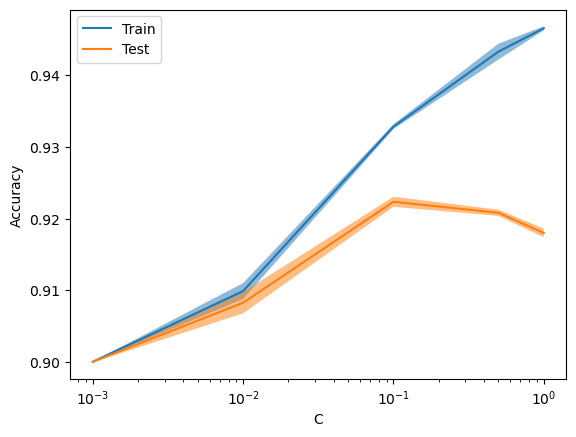

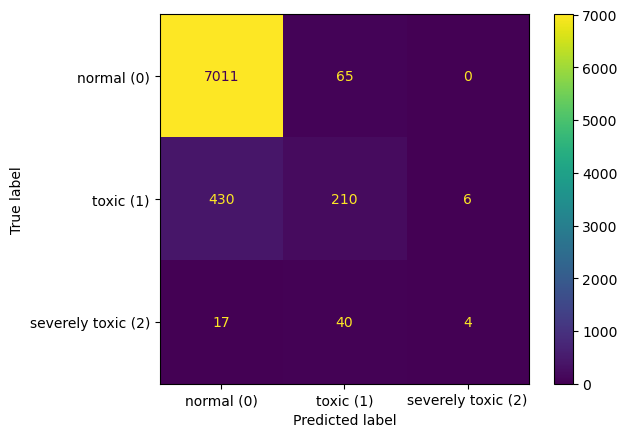

In [8]:
from sklearn.model_selection import train_test_split, ValidationCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Write code for task 2 here

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2025)
C_values = np.array([0.001, 0.01, 0.1, 0.5, 1.0])
logistic_regression_baseline = LogisticRegression(random_state = 2025)
VCS_display = ValidationCurveDisplay.from_estimator(logistic_regression_baseline, X_train, y_train, param_name = 'C', param_range = C_values, scoring = 'accuracy', cv = 3)
best_C = C_values[np.argmax(VCS_display.test_scores.mean(axis = 1))]
logistic_regression_final = LogisticRegression(random_state = 2025, C = best_C)
logistic_regression_final.fit(X_train, y_train)
y_prediction = logistic_regression_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_prediction)
cm = confusion_matrix(y_test, y_prediction)
cm_display = ConfusionMatrixDisplay(cm, display_labels = ["normal (0)", "toxic (1)", "severely toxic (2)"]).plot()
print("The optimal C value that I selected based on the validation curve results is", best_C)
print("The test accuracy is", test_accuracy)

## Task 3

Carefully inspect the confusion matrix of your final model from task 2. You should observe that while the overall accuracy is reasonably high (likely above 90%), the per-class accuracy is lowest for toxic comments! You should also note that there are far fewer of these kinds of examples compared to normal comments. This phenomenon is called *data imbalance*.

### Understanding Different Types of Errors and Their Costs

In toxicity detection for content moderation, different types of errors have different consequences:

- **False Negatives (Missing Toxic Content)**: Failing to detect truly toxic content means harmful speech remains visible, potentially harming users and violating platform policies
- **False Positives (Over-flagging Normal Content)**: Incorrectly flagging normal content as toxic can lead to inappropriate censorship, frustrated users, and suppression of legitimate discourse

For severely toxic content specifically, false negatives may be particularly costly since this content is most harmful. Consider how precision and recall trade off differently for each class in your confusion matrix.

### Addressing Data Imbalance

For this task, experiment with each of the following methods for addressing data imbalance:

1. **Resampling**: Create a new balanced training set with roughly equal numbers of normal, toxic, and severely toxic comments. You can use:
   - **Upsampling**: Randomly duplicate examples from minority classes (toxic and severely toxic) to match the majority class size
   - **Downsampling**: Randomly select a subset of examples from the majority class (normal) to match the minority class sizes
   
   You can implement this using scikit-learn's [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) function or write code yourself using NumPy's random sampling. **Important**: Do not resample your test set; leave it unbalanced and representative of the original predictive task.

2. **Class reweighting**: Leave the dataset unchanged but reweight the loss associated with errors on different classes during model optimization. Use the `class_weight='balanced'` parameter in [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), which automatically sets weights in inverse proportion to class frequencies (rare classes like severely toxic get higher weights during optimization).

Implement both approaches and report your results by computing and visualizing the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) on the test set for each approach. Use the same regularization parameter `C` as selected in task 2.

Select one of the results as your final model and explain your choice by:
1. Discussing which types of errors (false positives vs false negatives) are more acceptable in a content moderation context
2. Explaining how your chosen method balances these competing concerns

The C value I used is 0.1
The test accuracy for the resampling model is 0.8071437748939997


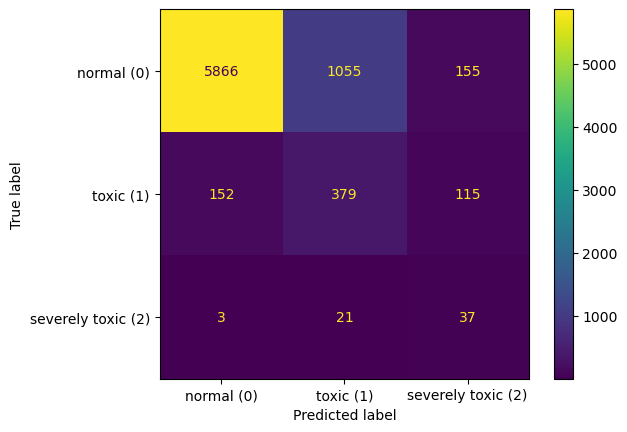

In [10]:
from sklearn.utils import resample
from scipy.sparse import vstack
# Write code for task 3 here

classes, counts = np.unique(y_train, return_counts = True)
X_sample = []
y_sample = []
for label in classes:
    X_with_label = X_train[y_train == label]
    y_with_label = y_train[y_train == label]
    X_resample, y_resample = resample(X_with_label, y_with_label, n_samples = counts.max(), random_state = 2025)
    X_sample.append(X_resample)
    y_sample.append(y_resample)
new_X_train = vstack(X_sample)
new_y_train = np.concatenate(y_sample)
resampling_model = LogisticRegression(random_state = 2025, C = best_C)
resampling_model.fit(new_X_train, new_y_train)
y_prediction_resampling = resampling_model.predict(X_test)
test_accuracy_resampling = accuracy_score(y_test, y_prediction_resampling)
cm_resampling = confusion_matrix(y_test, y_prediction_resampling)
cm_display_resampling = ConfusionMatrixDisplay(cm_resampling, display_labels = ["normal (0)", "toxic (1)", "severely toxic (2)"]).plot()
print("The C value I used is", best_C)
print("The test accuracy for the resampling model is", test_accuracy_resampling)

The C value I used is 0.1
The test accuracy for the class reweighting model is 0.8153668251316973


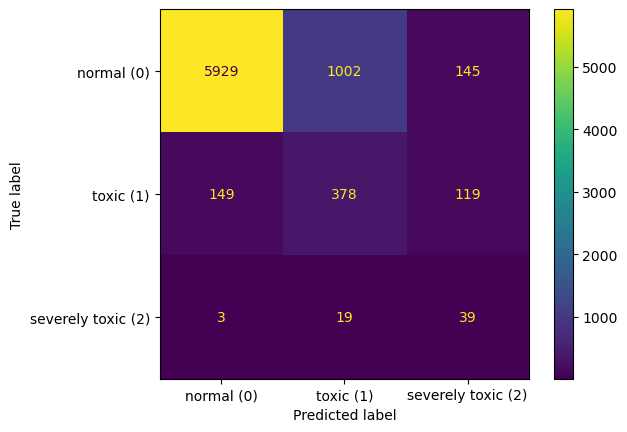

In [11]:
class_reweighting_model = LogisticRegression(random_state = 2025, C = best_C, class_weight = 'balanced')
class_reweighting_model.fit(X_train, y_train)
y_prediction_class_reweighting = class_reweighting_model.predict(X_test)
test_accuracy_class_reweighting = accuracy_score(y_test, y_prediction_class_reweighting)
cm_class_reweighting = confusion_matrix(y_test, y_prediction_class_reweighting)
cm_display_class_reweighting = ConfusionMatrixDisplay(cm_class_reweighting, display_labels = ["normal (0)", "toxic (1)", "severely toxic (2)"]).plot()
print("The C value I used is", best_C)
print("The test accuracy for the class reweighting model is", test_accuracy_class_reweighting)

To select a final model, we need to consider which has more severe consequences, either false positives or false negatives. With false positives, we may over-flag normal content which would lead to some consequences such as frustrating users, and supressing free speach. So it is suggested that we find a model that has low false positive cases for normal content. However, with false negatives, we may potentially miss to moderate toxic content, which means that harmful posts may remain visible that could harm users. I find the consequences for false negatives to be more severe and thus we should heavily focus on finding a model that has very few false negative cases for severely toxic content. In my opinion, I would prioritize more on lower false negative cases for severely toxic content than on lower false positive cases for normal content, although having both low false negatives and false positives would be great.

Based on the results, the final model I be selecting is the class weighting method model. For starter, it has less false negatives for severely toxic content with 22 cases compared to the resampling method model with 24 cases. This means that the class weighting method model does tend to fail to detect severely toxic content less times than the resampling method model. Plus, the class weighting method model has less false positives for normal content with 1,147 compared to the resampling method model with 1,210 cases. With that, it means that the class weighting method model tend to over-flag normal content less times than the resampling method model as well. Since there are less false positives for normal content, less false negatives for severely toxic content, and even achieves slightly higher accuracy, I am going with class weighting method model as my final model.

# Task 4

Machine learning continues to be applied for content moderation to detect and remove hate speech. For example, read [Meta's discussion](https://ai.meta.com/blog/ai-advances-to-better-detect-hate-speech/) of AI hate speech detection advances at the company. There is an obvious advantage to automated machine learning models to deal with the scale of data on modern social media platforms. Others are skeptical about relying on machine learning models for this purpose. For example, also read [A Brave New World of Mediated Online Discourse](https://cacm.acm.org/opinion/a-brave-new-world-of-mediated-online-discourse/), a 2022 opinion piece in the Communications of the ACM (the leading computer science professional society).

In 2-3 paragraphs, take a position on the question "Should machine learning models be used to automatically detect and/or remove toxic speech from social media platforms?" Briefly substantiate your position referencing the above articles or other sources of your own choosing.

In my opinion, I say that machine learning should be used to automatically detect and remove toxic speech from social media platforms. For me, the main reason is the scale and speed of ML as machine learning would be able to scan millions of online content and flag the ones that may violate social media policies, which is much faster than doing it manually. On the Meta discussion, it was mentioned that AI detects 88.8% of hate-speech removals and took action on 9.6 million content that violated hate speech policies.

However, I do think that machine learning models need to tackle some of the challenges it faces currently. Like the accuracy concerns for ML. In the second article, it was mentioned that mose commerical models only reaches 70% to 80% which is a big deal since one out of five content could be misclassified as toxic content. Also, ML algorithms may struggle with irony and humor content for example that could flag non-toxic content and lead to over-censorship.

Ultimately, I think the best use of this is to use machine learning to find toxic content and then use human judgement to decide on an action like moderate the content.